# Geoprocessing in python MAP
## 23.01.2023
#### Shawn Schneidereit

# Content

*
*
*

# Packages

In [1]:
import ee
import os
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import json
import geojson



import scipy
from osgeo import gdal, ogr
from sh import gunzip


# geopy10_fun.py must be in your working directory
import geopy10_fun as geopy


In [2]:

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

### Visualization parameters

In [3]:
# Sentinel-2 surface reflectance
s2Vis = {"bands": ["B4", "B3", "B2"], "min":0, "max": 1200}

# NDVI color palette
ndviVis = {"palette": ['white', 'green'], "min":0.2, "max": 1}

## Import wetland mask

In [4]:
# set folder location
fn_wetland = "/Users/shawn/Documents/humbolt/semester_05/geo_processing/MAP/wetland_mask.tif"
# Open data source
ds_wetland = gdal.Open(fn_wetland)

# get geotransformation meta data
ulx, xres, xskew, uly, yskew, yres  = ds_wetland.GetGeoTransform()
lrx = ulx + (ds_wetland.RasterXSize * xres)
lry = uly + (ds_wetland.RasterYSize * yres)

In [5]:
wetland_mask = ee.Image("projects/geoprocessing-python/assets/wetland_mask") 



# Download environmental variables

For the data sourced from DWD I implemted a import pipe line that dynamically generated a download link for each time step, gets the data, unzips it, and crops and transforms the data to match my wetland mask. Unfortunatly it was not straight forward to define a function for this, as the url structure changes from source to source. 

## Drought index

In [ ]:
import wget
# initialize time step variables
years = ["2017", "2018", "2019", "2020", "2021", "2022"]
months = ["01","02","03","04","05","06","07","08","09","10","11","12"]
months_DE = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [ ]:
# starting at 0 index
i = 0
j = 0
for year in years :
    for month in months:
        # dynamic generation of url
        url = ("https://opendata.dwd.de/climate_environment/CDC/grids_germany/monthly/drought_index/"+ month + "_" + months_DE[j] + "/grids_germany_monthly_drought_index_" + year + month + ".asc.gz")

        # download file from server
        wget.download(url, ("drought_index/grids_germany_monthly_drought_index_" + year + month + ".asc.gz"))
        # unzip into a usable format
        gunzip("drought_index/grids_germany_monthly_drought_index_" + year + month + ".asc.gz")

        # define i/o paths
        path_asc = "/Users/shawn/Documents/humbolt/semester_05/geo_processing/MAP/drought_index/grids_germany_monthly_drought_index_"+ year + month + ".asc"
        path_tif = (path_asc[0:-3] + "tif")

        # Create option
        kwargs = {
            'format': 'GTiff',
            'outputSRS': "EPSG:31467" # cant transform here... needs to be SRS defined in the DWD documentation
        }
        # Perform file translation into tif
        gdal.Translate(path_tif, path_asc, **kwargs)
        # remove asc version of file
        os.remove(path_asc)

        # set folder location
        ### Using Wetland projection, as this is the dault for other data inputs for my ROI
        warp = gdal.Warp(path_tif,path_tif,dstSRS=ds_wetland.GetProjection(), outputBounds= [ulx, lry, lrx , uly])
        warp = None # Closes the files



        # giving an incrememt of 1 to j
        j = j + 1
        if j == 12: # reset counter after on full year (12 months)
            j=0

stack all bands (dates)

In [ ]:
# Custom helper function that return full file path of files in dir (source: stackoverflow)
def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

In [ ]:
# Custom helper funtion to stack and save all files in a dir as a tif
def stackdir(path, file_name):
    # build a VRT with all files in dir
    path

    ImageList = listdir_fullpath(path)

    #Build A VRT of all tif files in dir
    VRT = (path + file_name + "_stack.vrt")
    gdal.BuildVRT(VRT, ImageList, separate=True, callback=gdal.TermProgress_nocb)
    VRT

    # Save VRT as tif
    InputImage = gdal.Open(VRT, 0)  # open the VRT in read-only mode
    gdal.Translate((path + file_name + '_stack.tif'), InputImage, format='GTiff',
                creationOptions=['COMPRESS:DEFLATE', 'TILED:YES'],
                callback=gdal.TermProgress_nocb)
                
    del InputImage  # close the VRT

    # helper function to clean out all single date tif files 
    for filename in os.listdir(path):
        #print(filename)
        if filename not in (path + file_name + '_stack.tif'):
             os.remove(path + filename)

In [ ]:
stackdir('/Users/shawn/Documents/humbolt/semester_05/geo_processing/MAP/drought_index/', "drought_index")

### soil moisture 1x1km at 60cm depth under grass



In [ ]:
# starting at 0 index
i = 0
j = 0
for year in years :
    for month in months:
        # dynamic generation of url
        url = ("https://opendata.dwd.de/climate_environment/CDC/grids_germany/monthly/soil_moist/grids_germany_monthly_soil_moist_"+ year + month + ".asc.gz")

        # download file from server
        wget.download(url, ("soil_moister/grids_germany_monthly_soil_moister_" + year + month + ".asc.gz"))
        # unzip into a usable format
        gunzip("soil_moister/grids_germany_monthly_soil_moister_" + year + month + ".asc.gz")

        # define i/o paths
        path_asc = "/Users/shawn/Documents/humbolt/semester_05/geo_processing/MAP/soil_moister/grids_germany_monthly_soil_moister_"+ year + month + ".asc"
        path_tif = (path_asc[0:-3] + "tif")

        # Create option
        kwargs = {
            'format': 'GTiff',
            'outputSRS': "EPSG:31467" # cant transform here... needs to be SRS defined in the DWD documentation
        }
        # Perform file translation into tif
        gdal.Translate(path_tif, path_asc, **kwargs)
        # remove asc version of file
        os.remove(path_asc)

        # set folder location
        warp = gdal.Warp(path_tif,path_tif,dstSRS=ds_wetland.GetProjection(), outputBounds= [ulx, lry, lrx , uly])
        warp = None # Closes the files



        # giving an incrememt of 1 to j
        j = j + 1
        if j == 12: # reset counter after on full year (12 months)
            j=0

In [ ]:
# build a VRT with all files in dir
stackdir('/Users/shawn/Documents/humbolt/semester_05/geo_processing/MAP/soil_moister/', "soil_moister")


### SMI: using Multi-annual grids of precipitation height over Germany 1981-2010 1x1km:


## First get the average precipitation per month

In [ ]:
# starting at 0 index
i = 0
j = 0
for year in years :
    for month in months:
        # dynamic generation of url
        url = ("https://opendata.dwd.de/climate_environment/CDC/grids_germany/monthly/precipitation/"+ month + "_" + months_DE[j] + "/grids_germany_monthly_precipitation_" + year + month + ".asc.gz")

        # download file from server
        wget.download(url, ("precipitation/precipitation_" + year + month + ".asc.gz"))
        # unzip into a usable format
        gunzip("precipitation/precipitation_" + year + month + ".asc.gz")

        # define i/o paths
        path_asc = "/Users/shawn/Documents/humbolt/semester_05/geo_processing/MAP/precipitation/precipitation_"+ year + month + ".asc"
        path_tif = (path_asc[0:-3] + "tif")

        # Create option
        kwargs = {
            'format': 'GTiff',
            'outputSRS': "EPSG:31467" # cant transform here... needs to be SRS defined in the DWD documentation
        }
        # Perform file translation into tif
        gdal.Translate(path_tif, path_asc, **kwargs)
        # remove asc version of file
        os.remove(path_asc)

        # set folder location
        warp = gdal.Warp(path_tif,path_tif,dstSRS=ds_wetland.GetProjection(), outputBounds= [ulx, lry, lrx , uly])
        warp = None # Closes the files
        
        # giving an incrememt of 1 to j
        j = j + 1
        if j == 12: # reset counter after on full year (12 months)
            j=0

In [ ]:
# build a VRT with all files in dir
stackdir('/Users/shawn/Documents/humbolt/semester_05/geo_processing/MAP/precipitation/', "precipitation")

## Then download the long term values from 1971-2010 


##### Then get the long term percipitation values over the past 40 years to compute long term means and standard deviation inputs needed to compute SPI

In [ ]:
years = (np.arange(1970,2011))
years = list(map(str, years))

In [ ]:
# starting at 0 index
i = 0
j = 0
for year in years :
    for month in months:
        # dynamic generation of url
        url = ("https://opendata.dwd.de/climate_environment/CDC/grids_germany/monthly/precipitation/"+ month + "_" + months_DE[j] + "/grids_germany_monthly_precipitation_" + year + month + ".asc.gz")

        # download file from server
        wget.download(url, ("precipitation_1970-2010/precipitation_" + year + month + ".asc.gz"))
        # unzip into a usable format
        gunzip("precipitation_1970-2010/precipitation_" + year + month + ".asc.gz")

        # define i/o paths
        path_asc = "/Users/shawn/Documents/humbolt/semester_05/geo_processing/MAP/precipitation_1970-2010/precipitation_"+ year + month + ".asc"
        path_tif = (path_asc[0:-3] + "tif")

        # Create option
        kwargs = {
            'format': 'GTiff',
            'outputSRS': "EPSG:31467" # cant transform here... needs to be SRS defined in the DWD documentation
        }
        # Perform file translation into tif
        gdal.Translate(path_tif, path_asc, **kwargs)
        # remove asc version of file
        os.remove(path_asc)

        # set folder location
        warp = gdal.Warp(path_tif,path_tif,dstSRS=ds_wetland.GetProjection(), outputBounds= [ulx, lry, lrx , uly])
        warp = None # Closes the files
        
        # giving an incrememt of 1 to j
        j = j + 1
        if j == 12: # reset counter after on full year (12 months)
            j=0

In [ ]:
# build a VRT with all files in dir
stackdir('/Users/shawn/Documents/humbolt/semester_05/geo_processing/MAP/precipitation_1970-2010/', "precipitation")

## Compute SMI

SPI = (P-P*) /  σp

__**where P = precipitation**__
__**p = mean historic precipitation**__
__**σp = standard deviation of precipitation**__


#### Additonally of indicies are aggregated with a moving window of three months to better reflect the seasonal and cumulative drought effects

##### Create binary wetland raster to mask climate variables via raster algebra and broadcasting

In [ ]:
# get subprocess to call GDAL util
import subprocess

# define paths to raster and vector
inraster = '/Users/shawn/Documents/humbolt/semester_05/geo_processing/MAP/wetland_mask_1km.tif'
inshape = '/Users/shawn/Documents/humbolt/semester_05/geo_processing/MAP/wetland_mask_vector/wetland_mask.shp'

# make gdal_rasterize command - will burn value 0 to raster where polygon intersects 
cmd = ('gdal_rasterize -burn 0 -i '+ inshape + ' ' + inraster)

# run command
subprocess.call(cmd, shell=True)

# make gdal command to subset to only first band (apperently no option to this in rasterize)
#cmd = ("gdal_translate -b 1 " + inraster + " " + inraster)
#subprocess.call(cmd, shell=True)



In [ ]:


wetland_mask_raster_src = gdal.Open("/Users/shawn/Documents/humbolt/semester_05/geo_processing/MAP/wetland_mask_1km.tif")
wetland_mask_raster = wetland_mask_raster_src.GetRasterBand(1).ReadAsArray()

# Convert to binary
wetland_mask_raster[wetland_mask_raster >0] = 1
wetland_mask_raster = wetland_mask_raster.astype(float)
wetland_mask_raster[wetland_mask_raster ==0] = np.nan # set no data value to nan in order to not influence downstream compurations and aggregations

##### mask values outside of wetland areas by multiplying by zero

In [ ]:
precipitation_src = gdal.Open("/Users/shawn/Documents/humbolt/semester_05/geo_processing/MAP/precipitation/precipitation_stack.tif")
precipitation = (precipitation_src.ReadAsArray()) 
precipitation = precipitation.astype(float)
precipitation[precipitation == -999] = "nan"
# mask via raster algebra and broadcasting 
### currently commmented out as I decided it make more sence to compile a complete tif for the ROI and can subset the data when preping the data for ML prediction
#precipitation = precipitation*wetland_mask_raster


#### Function to compute moving Window average 
(Window truncated in first 2 months)

In [ ]:
def moving_window_mean(input_stack, output_stack):

    for i in range(input_stack.shape[0]) :
        if i == 0:
            moving_window = copy.copy(input_stack[i])
            output_stack[i] = moving_window

        if i > 0:
            moving_window = copy.copy(input_stack[i-1:i,])
            output_stack[i] = np.nanmean(moving_window, axis=(0))

        if i > 1:
            moving_window = copy.copy(input_stack[i-2:i,])
            output_stack[i] = np.nanmean(moving_window, axis=(0))

        if i > 2:
            moving_window = copy.copy(input_stack[i-3:i,])
            output_stack[i] = np.nanmean(moving_window, axis=(0))

In [ ]:
precipitation_smothed = np.zeros(precipitation.shape)
moving_window_mean(precipitation, precipitation_smothed)

#### Agregate the mean and std for long term precipitation 

In [ ]:
precipitation_1970_2010_src = gdal.Open("/Users/shawn/Documents/humbolt/semester_05/geo_processing/MAP/precipitation_1970-2010/precipitation_stack.tif")
precipitation_1970_2010 = (precipitation_1970_2010_src.ReadAsArray()) 
precipitation_1970_2010 = precipitation_1970_2010.astype(float)
precipitation_1970_2010[precipitation_1970_2010 == -999] = np.nan
# mask via raster algebra and broadcasting 
#precipitation_1970_2010 = precipitation_1970_2010*wetland_mask_raster


The logic below it to index with i+every 12 band. This allows to compute the mean and std for each month across the previous 40 years

In [ ]:
# intialize empty arrays to be populated in the loop 
precipitation_1970_2010_mean = np.zeros([12]+list(precipitation.shape[1:]))
precipitation_1970_2010_std  = np.zeros([12]+list(precipitation.shape[1:]))

for i in np.arange(12):
    precipitation_1970_2010_mean[i] = np.nanmean(precipitation_1970_2010[i::12], axis=0)
    precipitation_1970_2010_std[i] = np.nanstd(precipitation_1970_2010[i::12], axis=0)


In [ ]:
precipitation_1970_2010_mean_smoothed = np.zeros(precipitation_1970_2010_mean.shape)
precipitation_1970_2010_std_smoothed = np.zeros(precipitation_1970_2010_std.shape)
moving_window_mean(precipitation_1970_2010_mean, precipitation_1970_2010_mean_smoothed)
moving_window_mean(precipitation_1970_2010_std, precipitation_1970_2010_std_smoothed)

#### Compute SPI

Dynamically index yearly precipitation values, while keeping the long term mean and standard deviation fixed

In [ ]:
# inital the array with first 12 months. The SPI for the rest of the time series are appened in the loop
SPI = (precipitation_smothed[0:12]-precipitation_1970_2010_mean_smoothed)/(precipitation_1970_2010_std_smoothed)
for i in np.arange(1,precipitation_smothed.shape[0]/12):
    start_index = int(i*12)
    end_index =   int((start_index + 12))
    SPI_temp = (precipitation_smothed[start_index:end_index]-precipitation_1970_2010_mean_smoothed)/(precipitation_1970_2010_std_smoothed)
    SPI = np.concatenate((SPI,SPI_temp))
   

#### Apply moving window to soil moister and drought index

In [ ]:
drought_index_src = gdal.Open("/Users/shawn/Documents/humbolt/semester_05/geo_processing/MAP/drought_index/drought_index_stack.tif")
drought_index = (drought_index_src.ReadAsArray()) 
drought_index = drought_index.astype(float)
drought_index[drought_index == -999] = np.nan
# mask via raster algebra and broadcasting 
#drought_index = drought_index*wetland_mask_raster

drought_index_smoothed = np.zeros(drought_index.shape)
moving_window_mean(drought_index, drought_index_smoothed)

In [ ]:
soil_moister_src = gdal.Open("/Users/shawn/Documents/humbolt/semester_05/geo_processing/MAP/soil_moister/soil_moister_stack.tif")
soil_moister = (soil_moister_src.ReadAsArray()) 
soil_moister = soil_moister.astype(float)
soil_moister[soil_moister == -9999] = np.nan  # Utterly critical. For unexplaned reason the DWD set the no data value to -9999 instead of the -999 used in every other dataset... thanks.....
# mask via raster algebra and broadcasting 
#soil_moister = soil_moister*wetland_mask_raster

soil_moister_smoothed = np.zeros(soil_moister.shape)
moving_window_mean(soil_moister, soil_moister_smoothed)
#soil_moister_smothed[soil_moister_smothed == 255] = np.nan


#### Save smoothed and formated  environmental time series to tifs

In [ ]:
# Modified from source: https://gis.stackexchange.com/questions/213937/in-gdal-how-to-save-3-dimensional-array-as-stacked-raster-image
def array_to_tif(out_path, Array, driver, no_data_value, 
                  GeoTransformation, Projection, DataType):
    Array[np.isnan(Array)] = no_data_value
    DataSet = driver.Create(out_path, Array.shape[2], Array.shape[1], Array.shape[0], DataType)
    DataSet.SetGeoTransform(GeoTransformation)
    DataSet.SetProjection(Projection)
    for i, image in enumerate(Array, 1):
        DataSet.GetRasterBand(i).WriteArray( image )
        DataSet.GetRasterBand(i).SetNoDataValue(no_data_value)
    DataSet.FlushCache()
    return out_path

In [ ]:
# define basis parameters
driver = gdal.GetDriverByName("GTiff")
GeoTransformation = precipitation_src.GetGeoTransform()
projection = precipitation_src.GetProjection()
DataType = gdal.GDT_Float32

out_path = "/Users/shawn/Documents/humbolt/semester_05/geo_processing/MAP/SPI/SPI.tif"
array_to_tif(out_path,SPI,driver,-9999,GeoTransformation,projection, DataType)

out_path = "/Users/shawn/Documents/humbolt/semester_05/geo_processing/MAP/drought_index/drought_index_smoothed.tif"
array_to_tif(out_path,drought_index_smoothed,driver,-9999,GeoTransformation,projection, DataType)

out_path = "/Users/shawn/Documents/humbolt/semester_05/geo_processing/MAP/soil_moister/soil_moister_smoothed.tif"
array_to_tif(out_path,soil_moister_smoothed,driver,-9999,GeoTransformation,projection, DataType)

### Potentially soil data from GEE data catalog (USDA so would need significant cleaning and aggregation of classes, especially since from what I can tell random forest in skikit-learn only allows for hot-coding of categorical variables)


# Transform all to common CRS and use raster math to mask to relevant wetland areas

Actually not needed as GEE can deal with projections on the fly


In [ ]:
filename = "/Users/shawn/Documents/humbolt/semester_05/geo_processing/MAP/drought_index/drought_index_smoothed.tif"
input_raster = gdal.Open(filename)
output_raster = "/Users/shawn/Documents/humbolt/semester_05/geo_processing/MAP/drought_index/drought_index_smoothed_espg3857.tif"
warp = gdal.Warp(output_raster,input_raster,dstSRS='EPSG:3857')
warp = None # Closes the files

Import environmental variables (uploaded from local to GEE project folder)

In [6]:
drought_index = ee.Image("projects/geoprocessing-python/assets/drought_index") 
soil_moister = ee.Image("projects/geoprocessing-python/assets/soil_moister") 
SPI = ee.Image("projects/geoprocessing-python/assets/SPI") 

In [7]:
bbox = drought_index.geometry()

## Get NDVI time series from GEE data catalog


### Set up map window


In [8]:
Map = geemap.Map(center=[52.8, 11.5], zoom=7)
Map.add_basemap('HYBRID')
#Map


In [9]:
# Sentinel-2 surface reflectance
droughtVis = {"bands": ["b1"],"palette": ['blue',"yellow","orange","red", 'red'], "min":0, "max": 11}

# NDVI color palette
#ndviVis = {"palette": ['white', 'green'], "min":0.2, "max": 1}

In [10]:
#Map.addLayer(drought_index, droughtVis, "drought_index")


#### Below is code to generate a two property list from a static month and year range. The idea was to modify the calc_NDVI function to take two input parameters (in a dictionary or other data structure) and then map across this list. Would have been an elogent solution, but unfortunatly this does not seem to be possible. While i can see the month and year values in the output window, for the values to actually be accessable i need to use getinfo(). When attempting to do this using the map function it triggers an error since a client side process is being called in a server side computation. After extensive googleing and attempting to hack together a solution I was not able to find a way. Equally it is not possible to start out with "normal" python dictionary an converting them to ee.lists inside of the  monthlyNdviMedian function, as using map for a ee.ImageCollection will only let you map across an ee.list(). 

In [11]:
def get_year_month_combinations(start_year, end_year, start_month, end_month):
    years = ee.List.sequence(start_year, end_year)
    months = ee.List.sequence(start_month, end_month)

    year_month_combinations = years.map(lambda y: 
                                          months.map(lambda m: 
                                            ee.Dictionary({"year": y, "month": ee.Number(m).int8()})))

    return year_month_combinations.flatten()

In [12]:
year_month_combinations = get_year_month_combinations(2017, 2022, 1, 12)
combination = year_month_combinations.get(0)
combination

In [13]:
# checking data types for possible workarounds to feed the data into the monthlyNdviMedian fucniton
combination_list = year_month_combinations.getInfo()
first_combination = combination_list[0]
month = first_combination["month"]
year = first_combination["year"]
type(year_month_combinations), type(combination_list), type(first_combination)

(ee.ee_list.List, list, dict)

### SO I found a solution that completely removed the need for using the map function. This defenelty results in a slower computation as was very challenging to implement but it works... 

In [14]:
# Function to get all year and month combinations
def get_year_month_combinations(start_year, end_year, start_month, end_month):
    year_month_combinations = [] # Initialize empty list to store combinations
    for year in range(start_year, end_year + 1): # Loop through years 
        for month in range(start_month, end_month + 1): # Loop through months for each year
            year_month_combinations.append(str(year) + "_" + str(month).zfill(2)) # Combine year and month into a string and append to list
    return year_month_combinations

In [15]:
# Function to get median NDVI for a given year-month combination (modified from Dirk)
def monthlyNdviMedian(combination_string):
    year, month = combination_string.split("_") # Split year-month combination into year and month
    year = int(year)
    month = int(month)

    # Filter images based on year and month
    dateFilter = ee.Filter.And(ee.Filter.calendarRange(month, month, "month"),
                               ee.Filter.date(ee.Date.fromYMD(year, 1, 1), 
                               ee.Date.fromYMD(year, 12, 31)))
    
    # Get Sentinal-2 image collection and calculate NDVI
    S2 = ee.ImageCollection("COPERNICUS/S2_SR") \
             .filter(dateFilter) \
             .filterBounds(bbox) \
             .filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", 70) \
             .map(geopy.maskCloudsS2) \
             .map(geopy.calcNdviS2)

    medianNdvi = S2.median()

    # Rename the median NDVI image with year-month and suffix
    return medianNdvi.rename(ee.Number(year).format().cat("_").cat(ee.Number(month).format()).cat(ee.String("_median_ndvi")))      

In [16]:
# Function to get median NDVI for all year-month combinations
def monthlyNdviMedianAll(year_month_combinations):
  image = ee.Image().select([]) # Initialize empty image

  for combination in year_month_combinations: # Loop through year-month combinations
    medianNdvi = monthlyNdviMedian(combination) # Get median NDVI for each combination
    image = image.addBands(medianNdvi) # Add the median NDVI to the empty image

  return image

In [17]:
year_month_combinations = get_year_month_combinations(2017, 2022, 1, 12)
medianNdviStack = monthlyNdviMedianAll(year_month_combinations)
#medianNdviStack

In [18]:
#Map.addLayer(medianNdviStack.select(["2017_5_median_ndvi"]), ndviVis, "median NDVI Stack")

## REMOVED AS ITS ONLY AVAILABLE FOR US.... 
#### GRIDMET DROUGHT: CONUS Drought Indices from GEE (4x4km spatial resolution)

No where in the GEE was it noted that this is US only... Fully implemented but useless as it does not cover study area. Thanks google

Here I use modifed code, following the same workflow from above. 

In [19]:
# Function to get GRIDMET for a given year-month combination (modified from Dirk)
def monthlyGRIDMET(combination_string):
    year, month = combination_string.split("_") # Split year-month combination into year and month
    year = int(year)
    month = int(month)

    # Filter images based on year and month
    dateFilter = ee.Filter.And(ee.Filter.calendarRange(month, month, "month"),
                               ee.Filter.date(ee.Date.fromYMD(year, 1, 1), 
                               ee.Date.fromYMD(year, 12, 31)))
    
    # Get Sentinal-2 image collection and calculate NDVI
    GRIDMET = ee.ImageCollection("GRIDMET/DROUGHT") \
             .filter(dateFilter) \
             .filterBounds(bbox) \
             .select(['spei30d', 'eddi30d', 'pdsi']) # select the relavent target bands (Standardized Precipitation Evapotranspiration Index (SPEI)(monthly), Evaporative Drought Demand Index (EDDI)(monthly), Palmer Drought Severity Index (pdsi))

    GRIDMET = GRIDMET.median() \
              .rename(ee.Number(year).format().cat("_").cat(ee.Number(month).format()).cat(ee.String("_SPEI")), \
                      ee.Number(year).format().cat("_").cat(ee.Number(month).format()).cat(ee.String("_EDDI")), \
                      ee.Number(year).format().cat("_").cat(ee.Number(month).format()).cat(ee.String("_PDSI"))  \
                     )


    # Rename the GRIDMET image with year-month and suffix
    return GRIDMET#.rename(ee.Number(year).format().cat("_").cat(ee.Number(month).format()).cat(ee.String("_GRIDMET")))      

In [20]:
# Function to get median NDVI for all year-month combinations
def monthlyGRIDMETAll(year_month_combinations):
  image = ee.Image().select([]) # Initialize empty image

  for combination in year_month_combinations: # Loop through year-month combinations
    GRIDMET = monthlyGRIDMET(combination) # Get median NDVI for each combination
    image = image.addBands(GRIDMET) # Add the median NDVI to the empty image

  return image

In [21]:
#GRIDMETstack = monthlyGRIDMETAll(year_month_combinations)

### Import OpenLandMap Predicted Hapludalfs Probability (Predicted USDA soil great groups at 250 m (probabilities))

In [22]:
soil_type = ee.Image("OpenLandMap/SOL/SOL_GRTGROUP_USDA-SOILTAX-HAPLUDALFS_P/v01") \
             .clip(bbox) 

In [23]:
soilvis = {
  "bands": ['grtgroup'],
  "min": 0.0,
  "max": 35.0,
  "palette": ['ffffb2', 'fecc5c', 'fd8d3c', 'f03b20', 'bd0026']
}

#Map.addLayer(soil_type, soilvis, "soil_type")

#### OpenLandMap Soil Water Content at 33kPa (Field Capacity)

In [24]:
field_capacity = ee.Image("OpenLandMap/SOL/SOL_WATERCONTENT-33KPA_USDA-4B1C_M/v01").clip(bbox).reduce(ee.Reducer.median()).rename('field_capacity')

OpenLandMap Soil Bulk Density

In [25]:
soil_bulk_density = ee.Image("OpenLandMap/SOL/SOL_BULKDENS-FINEEARTH_USDA-4A1H_M/v02").clip(bbox).reduce(ee.Reducer.median()).rename('soil_bulk_density')

#### Import sample points

In [26]:
pts = ogr.Open("/Users/shawn/Documents/humbolt/semester_05/geo_processing/MAP/sample_points_regular/sample_points_regular.shp")
lyr = pts.GetLayer()

In [27]:
# check names in shp
[field.name for field in lyr.schema]

['id', 'FID']

#### Subset the whole sample_points feature collection to avoid memory issues 

In [28]:
import random

# Get the number of features in the layer
feature_count = lyr.GetFeatureCount()

# Generate a list of random indices
sample_size = 5000 # change this to the desired number of samples
random_indices = random.sample(range(feature_count), sample_size)

# Create a new layer to store the selected features
driver = ogr.GetDriverByName("ESRI Shapefile")
dst_ds = driver.CreateDataSource("/Users/shawn/Documents/humbolt/semester_05/geo_processing/MAP/sample_points_regular/sample_points_regular_subset.shp")
dst_layer = dst_ds.CreateLayer("selected_points", lyr.GetSpatialRef(), ogr.wkbPoint)

# Check if the lyr data source has an 'id' field
src_layer_defn = lyr.GetLayerDefn()
id_field_index = src_layer_defn.GetFieldIndex("id")
if id_field_index != -1:
    # Add an 'id' field to the destination layer if it exists in the source layer
    id_field = src_layer_defn.GetFieldDefn(id_field_index)
    dst_layer.CreateField(id_field)

# Loop through the random indices and extract the corresponding features
for i in random_indices:
    lyr.SetNextByIndex(i)
    feature = lyr.GetNextFeature()
    geom = feature.GetGeometryRef()
    if geom.GetGeometryType() == ogr.wkbMultiPoint:
        # Extract individual points from the multi-point feature
        for j in range(geom.GetGeometryCount()):
            point = geom.GetGeometryRef(j)
            new_feature = ogr.Feature(dst_layer.GetLayerDefn())
            new_feature.SetGeometry(point)
            if id_field_index != -1:
                new_feature.SetField("id", feature.GetField("id"))
            dst_layer.CreateFeature(new_feature)
    else:
        new_feature = ogr.Feature(dst_layer.GetLayerDefn())
        new_feature.SetGeometry(geom)
        if id_field_index != -1:
            new_feature.SetField("id", feature.GetField("id"))
        dst_layer.CreateFeature(new_feature)

# Clean up
# src_ds = None
dst_ds = None


In [29]:

pts = ogr.Open("/Users/shawn/Documents/humbolt/semester_05/geo_processing/MAP/sample_points_regular/sample_points_regular_subset.shp")
lyr2 = pts.GetLayer()
# check names in shp
[field.name for field in lyr2.schema]

['id']

In [30]:
# creat google earth feature collection for server side processing
featList = [] # Instantiate a list that we populate with the features
feat = lyr2.GetNextFeature()
while feat:
    id = feat.GetField('id')
    #print(id)
    # -----------------------------------------
    geom = feat.geometry()
    geom_json = json.loads(geom.ExportToJson())
    geom_coord = geom_json['coordinates']
    geom_EE = ee.Geometry.Point(coords=geom_coord, proj="EPSG:5653") # critical to hard code define the espg definition
    # Create ee.Feature(), append to list
    eeFeat = ee.Feature(geom_EE, {"UniqueID": id})
    featList.append(eeFeat)

    # -----------------------------------------
    feat = lyr2.GetNextFeature()
lyr2.ResetReading()

len(featList)

5000

In [31]:
fc = ee.FeatureCollection(ee.List(featList))


#### A unelagent but funcitonal method to rename bands from generic b1,b2,... to a combination of year month and data type (this allows subsequent filtering in the next step)

In [32]:
years = [2017, 2018, 2019, 2020, 2021, 2022]
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

band_names = [str(year) + "_" + str(month) + "_drought_index" for year in years for month in months]
drought_index = drought_index.rename(ee.List(band_names))

band_names = [str(year) + "_" + str(month) + "_soil_moister" for year in years for month in months]
soil_moister = soil_moister.rename(ee.List(band_names))

band_names = [str(year) + "_" + str(month) + "_SPI" for year in years for month in months]
SPI = SPI.rename(ee.List(band_names))


In [33]:
allRas = medianNdviStack.addBands([drought_index, soil_moister, SPI, soil_type, field_capacity, soil_bulk_density])
type(allRas)

ee.image.Image

#### Subset each data source to contain only the relavent bands for each year and month combinaiton

In [34]:
allRas_subsets = {}

for year in years:
    for month in months:
        medianNdviStack = "{}_{}_median_ndvi".format(year, month)
        drought_band = "{}_{}_drought_index".format(year, month)
        soil_moister_band = "{}_{}_soil_moister".format(year, month)
        SPI_band = "{}_{}_SPI".format(year, month)
        soil_type = "grtgroup"
        field_capacity = "field_capacity"
        soil_bulk_density = "soil_bulk_density"
        
        
        year_month_image = allRas.select([medianNdviStack, drought_band, soil_moister_band, SPI_band, soil_type,field_capacity, soil_bulk_density])
        
        key = "{}_{}".format(year, month)  # found on the interwebs. Neat, but dont if I like it or if its best pratice...
        allRas_subsets[key] = year_month_image

In [35]:
year_month = "2017_5" 
allRas_subset = allRas_subsets[year_month]


In [36]:
band_names = allRas_subset.bandNames()
#print('Band names:', band_names.getInfo())  # ee.List of band names

#### Extract the raster data for the sample ponts 

In [37]:
vals = allRas_subset.sampleRegions(collection=fc, properties=['UniqueID'], scale=10, tileScale=4, geometries=False).getInfo()
#vals

In [87]:
flag = 0
featureValues = vals['features']
for f in featureValues:
 # Chekc here always the right order of the indices
    prop = f['properties']
    if flag == 0:
        out_pd = pd.DataFrame(prop, index=[0])
        flag = 1
    else:
        out_pd = pd.concat([out_pd, pd.DataFrame(prop, index=[0])])
out_pd.head()

,2017_5_SPI,2017_5_drought_index,2017_5_median_ndvi,2017_5_soil_moister,UniqueID,field_capacity,grtgroup,soil_bulk_density
0,-0.037208,2.666667,0.919937,64.666664,775849,25.0,25,146.5
0,0.155271,2.333333,0.842228,65.000000,405232,35.0,14,133.0
0,-0.456887,2.000000,0.752873,61.333332,1065135,25.5,19,147.5
0,0.756059,2.333333,0.804369,65.666664,472782,25.0,27,147.0
0,-0.010885,2.000000,0.910751,65.000000,428338,41.0,22,132.5


## Split data (either random 30/70, or could use BB points to predict MV or visa versa)


### Parameterize classifiers locally 

#### Extract feature target array


In [104]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics


# Create the two arrays
y = out_pd['2017_5_median_ndvi']
X = out_pd.drop(['2017_5_median_ndvi', 'UniqueID'], axis=1)

##### soil type renaming

In [105]:
soil_names = df = pd.read_csv("/Users/shawn/Documents/humbolt/semester_05/geo_processing/MAP/USDA Soil Taxonomy Great Groups.csv")
soil_names= soil_names.rename(columns={"Value": "grtgroup", "Description": "soil_type"})
soil_names.head()

,grtgroup,Color,soil_type
0,0,FFFFFF,NODATA
1,1,ADFF2D,Albaqualfs
2,2,ADFF22,Cryaqualfs
3,4,A5FF2F,Durixeralfs
4,6,87FF37,Endoaqualfs


In [106]:
X= X.join(soil_names[["grtgroup","soil_type"]].set_index('grtgroup'), on='grtgroup').drop("grtgroup", axis=1)
X

,2017_5_SPI,2017_5_drought_index,2017_5_soil_moister,field_capacity,soil_bulk_density,soil_type
0,-0.037208,2.666667,64.666664,25.0,146.5,Natraqualfs
0,0.155271,2.333333,65.000000,35.0,133.0,Glossocryalfs
0,-0.456887,2.000000,61.333332,25.5,147.5,Haplustalfs
0,0.756059,2.333333,65.666664,25.0,147.0,Natrudalfs
0,-0.010885,2.000000,65.000000,41.0,132.5,NaN
...,...,...,...,...,...,...
0,-0.145000,1.666667,62.000000,24.0,151.0,NaN
0,0.125197,2.333333,66.000000,29.0,133.5,Glossudalfs
0,0.074870,1.666667,61.666668,29.0,135.5,Fragiaqualfs
0,-0.061427,1.666667,66.333336,25.0,146.0,Haploxeralfs


#### standardize the feature vector (z-transformation (zero mean and unit variance))
The data need to be scaled to remove unit and size imbalances between variables. Failing to do so would overweight some variables predictive significance soely based on there numeric size.

In [108]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
scaler = preprocessing.StandardScaler().fit(X.drop("soil_type", axis=1))
#X = scaler.transform(X)

In [109]:
X.head()

,2017_5_SPI,2017_5_drought_index,2017_5_soil_moister,field_capacity,soil_bulk_density,soil_type
0,-0.037208,2.666667,64.666664,25.0,146.5,Natraqualfs
0,0.155271,2.333333,65.000000,35.0,133.0,Glossocryalfs
0,-0.456887,2.000000,61.333332,25.5,147.5,Haplustalfs
0,0.756059,2.333333,65.666664,25.0,147.0,Natrudalfs
0,-0.010885,2.000000,65.000000,41.0,132.5,NaN


In [110]:
X[["2017_5_SPI","2017_5_drought_index","2017_5_soil_moister","field_capacity","soil_bulk_density"]] = StandardScaler().fit_transform(X[["2017_5_SPI","2017_5_drought_index","2017_5_soil_moister","field_capacity","soil_bulk_density"]])


In [111]:
# One-hot encode the data using pandas get_dummies
X['soil_type'] = pd.Categorical(X.soil_type)
X = pd.get_dummies(X, prefix='soil_type')
# Display the first 5 rows of the last 12 columns
X.head()

,2017_5_SPI,2017_5_drought_index,2017_5_soil_moister,field_capacity,soil_bulk_density,soil_type_Albaqualfs,soil_type_Cryaqualfs,soil_type_Durixeralfs,soil_type_Endoaqualfs,soil_type_Epiaqualfs,...,soil_type_Haplustalfs,soil_type_Natraqualfs,soil_type_Natrixeralfs,soil_type_Natrudalfs,soil_type_Natrustalfs,soil_type_Palecryalfs,soil_type_Paleudalfs,soil_type_Paleustalfs,soil_type_Palexeralfs,soil_type_Rhodustalfs
0,-0.191129,1.782676,0.792517,-1.044509,1.048266,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
0,0.859125,1.013709,0.949589,1.149169,-0.411751,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-2.481080,0.244744,-0.778198,-0.934825,1.156416,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
0,4.137282,1.013709,1.263731,-1.044509,1.102341,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
0,-0.047498,0.244744,0.949589,2.465376,-0.465826,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Tune hyperparameters

Shifted from a grid search to a random sampleling of the grid. Seems to be both quicker and provide better estimates, as a effecitvely a larger grid can be searched.

In [137]:
from sklearn.model_selection import RandomizedSearchCV

# Create a classifier instance
RF = RandomForestRegressor(random_state=1)
param_grid = {'n_estimators': [10, 25, 50, 75, 100],# 'numberOfTrees
              'max_features': [5, 10, 25, 'sqrt'],# 'variablesPerSplit'
              'min_samples_split': [5, 10, 15, 25], # minLeafPopulation
              'max_depth': [5, 10, 20, 50]} # maxNodes
#RF_cv = GridSearchCV(RF, param_grid=param_grid, cv=3, refit=True, n_jobs=8).fit(X, y)

TypeError: Parameter grid for parameter 'n_estimators' needs to be a list or a numpy array, but got <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7faa4b85e680> (of type rv_continuous_frozen) instead. Single values need to be wrapped in a list with one element.

In [154]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

RF_random = RandomizedSearchCV(estimator = RF, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=0, random_state=1, n_jobs = -1).fit(X, y)

/Users/shawn/opt/anaconda3/envs/anaconda_env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shawn/opt/anaconda3/envs/anaconda_env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shawn/opt/anaconda3/envs/anaconda_env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set 

#### evaluate best_mod parameters

In [113]:
#best_mod = RF_cv.best_estimator_
#best_mod

RandomForestRegressor(max_depth=50, max_features=10, min_samples_split=5,
                      n_estimators=75, random_state=1)

In [144]:
best_mod = RF_random.best_estimator_
best_mod

RandomForestRegressor(max_depth=70, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=30, random_state=1)

In [145]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
y_pred = best_mod.predict(X_val)

In [146]:
mae = metrics.mean_absolute_error(y_val, y_pred)
mse = metrics.mean_squared_error(y_val, y_pred)
rmse = mse**0.5

mae, rmse

(0.06872685137115327, 0.11726745194489499)

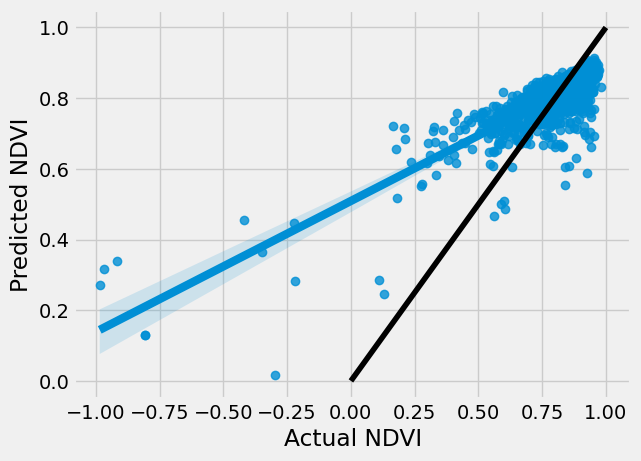

In [147]:
import seaborn as sns
#create scatterplot with regression line and confidence interval lines
sns.regplot(x=y_val, y=y_pred)
plt.plot([0,1], [0,1], 'black') #1 to 1 line
plt.ylabel('Predicted NDVI')
plt.xlabel('Actual NDVI')
# show the plot
plt.show()

### Get variable importance

In [148]:
# Get numerical feature importances
importances = list(best_mod.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: 2017_5_SPI           Importance: 0.24
Variable: soil_bulk_density    Importance: 0.21
Variable: field_capacity       Importance: 0.2
Variable: 2017_5_soil_moister  Importance: 0.17
Variable: 2017_5_drought_index Importance: 0.06
Variable: soil_type_Durixeralfs Importance: 0.02
Variable: soil_type_Epiaqualfs Importance: 0.02
Variable: soil_type_Endoaqualfs Importance: 0.01
Variable: soil_type_Fragiaqualfs Importance: 0.01
Variable: soil_type_Fragiudalfs Importance: 0.01
Variable: soil_type_Fragixeralfs Importance: 0.01
Variable: soil_type_Fraglossudalfs Importance: 0.01
Variable: soil_type_Glossaqualfs Importance: 0.01
Variable: soil_type_Glossocryalfs Importance: 0.01
Variable: soil_type_Glossudalfs Importance: 0.01
Variable: soil_type_Haploxeralfs Importance: 0.01
Variable: soil_type_Albaqualfs Importance: 0.0
Variable: soil_type_Cryaqualfs Importance: 0.0
Variable: soil_type_Haplocryalfs Importance: 0.0
Variable: soil_type_Hapludalfs Importance: 0.0
Variable: soil_type_Hapl

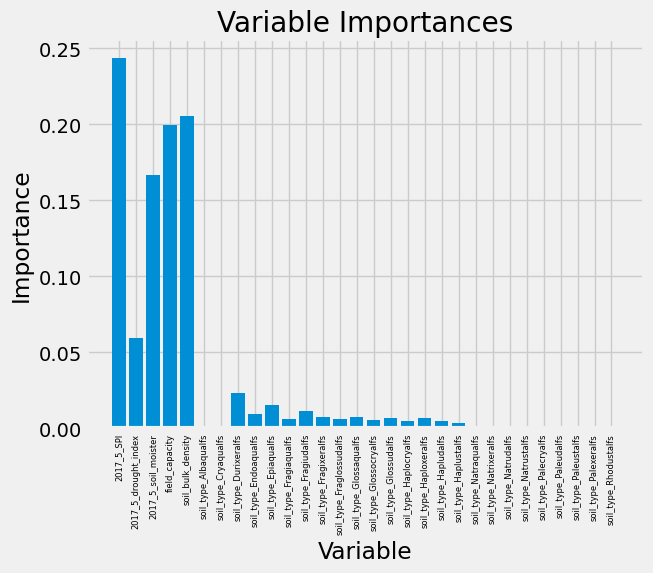

In [149]:
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, X, rotation= 90, size=6)
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

#### Setting up classification in GEE

#### Create string description of RF model that is interpretable in GEE

In [53]:
from geemap import ml
feature_names = X.columns.tolist() # get the names of the variables
best_mod_str = ml.rf_to_strings(best_mod, feature_names, output_mode= "REGRESSION" )  # IMPORTANT IS TO SET output_mode TO REGRESSION, OR ELSE THE STRING CONVERTION IS INCORRECT AND THE CLASSFICATION DOES NOT WORK
ee_classifier = ml.strings_to_classifier(best_mod_str)

ee_classifier

KeyboardInterrupt: 

In [ ]:
classification = allRas_subset.mask(wetland_mask).clip(bbox).classify(ee_classifier) # really shouldnt make a difference but get a memory error if I do not re-clip classificaiton. 
#classification



In [ ]:
Map.addLayer(classification, ndviVis , 'classification')

EEException: Image.classify: The image to be classified does not contain all the bands which the classifier expects.
  Image bands: [2017_5_median_ndvi, 2017_5_drought_index, 2017_5_soil_moister, 2017_5_SPI, grtgroup, field_capacity, soil_bulk_density].
  Classifier inputs: [2017_5_soil_moister, field_capacity, grtgroup_14, grtgroup_12, 2017_5_drought_index, grtgroup_18, soil_bulk_density, 2017_5_SPI, grtgroup_4, grtgroup_8].
  Missing bands: [grtgroup_4, grtgroup_12, grtgroup_8, grtgroup_14, grtgroup_18].

In [ ]:
ndvi = (str(year_month)+"_median_ndvi")

# Compute the difference between actual and predicted NDVI
diff = allRas_subset.select(ndvi).mask(wetland_mask).subtract(classification)

# Compute the squared difference between actual and predicted NDVI
#squared_difference = diff.pow(2)


In [ ]:
diffVis = {"palette": ['#440154', "#414487", "#2a788e", "#22a884", "#7ad151", "#fde725", 'red'], "min":0, "max": 1}

Map.addLayer(diff, diffVis , 'diff')
#Map.addLayer(squared_difference, diffVis , 'squared_difference')

#Map


In [53]:
Map


Map(center=[52.8, 11.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=…

##### create some scatter plots

In [ ]:

ndvi_compairison = (allRas_subset.select(ndvi).mask(wetland_mask).clip(bbox).addBands([classification])).mask(wetland_mask).clip(bbox)
ndvi_compairison


In [ ]:

values = ndvi_compairison.sample(region=bbox, scale=10, numPixels=50000, geometries=False).getInfo()

In [ ]:
flag = 0
featureValues = values['features']
for f in featureValues:
 # Chekc here always the right order of the indices
    prop = f['properties']
    if flag == 0:
        out_pd = pd.DataFrame(prop, index=[0])
        flag = 1
    else:
        out_pd = pd.concat([out_pd, pd.DataFrame(prop, index=[0])])
out_pd.head()

,2017_5_median_ndvi,classification
0,0.792766,0.774526
0,0.940976,0.859042
0,0.870252,0.720634
0,0.838761,0.797752
0,0.685972,0.734768


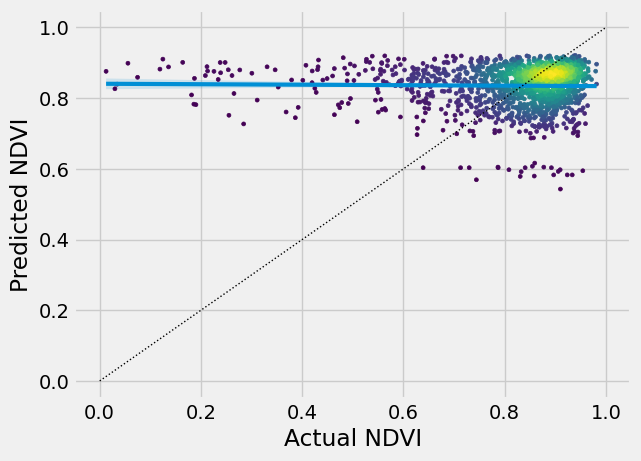

In [ ]:
from scipy.stats import gaussian_kde

# Calculate the point density
xy = np.vstack([out_pd[ndvi],out_pd["classification"]])
z = gaussian_kde(xy)(xy)

#create scatterplot with regression line and confidence interval lines
sns.regplot(x=out_pd[ndvi], y=out_pd["classification"], scatter=False, line_kws={'linewidth':3})
plt.scatter(x=out_pd[ndvi], y=out_pd["classification"],c=z, s=8 )
plt.plot([0,1], [0,1], 'black', linestyle='dotted', linewidth=1) #1 to 1 line
plt.ylabel('Predicted NDVI')
plt.xlabel('Actual NDVI')
# show the plot
plt.show()

# Apply trained model to the bigger test data set


# Create output maps